# Naive Bayes
- 2020-2 Artifitial Intelligence  
- week4 Assignment  
- Updated 0927
- 긍정부정 문서 데이터로 나이브베이즈 분류기 만들기
- 입력문장이 긍정(P)인지 부정(N)인지 분류

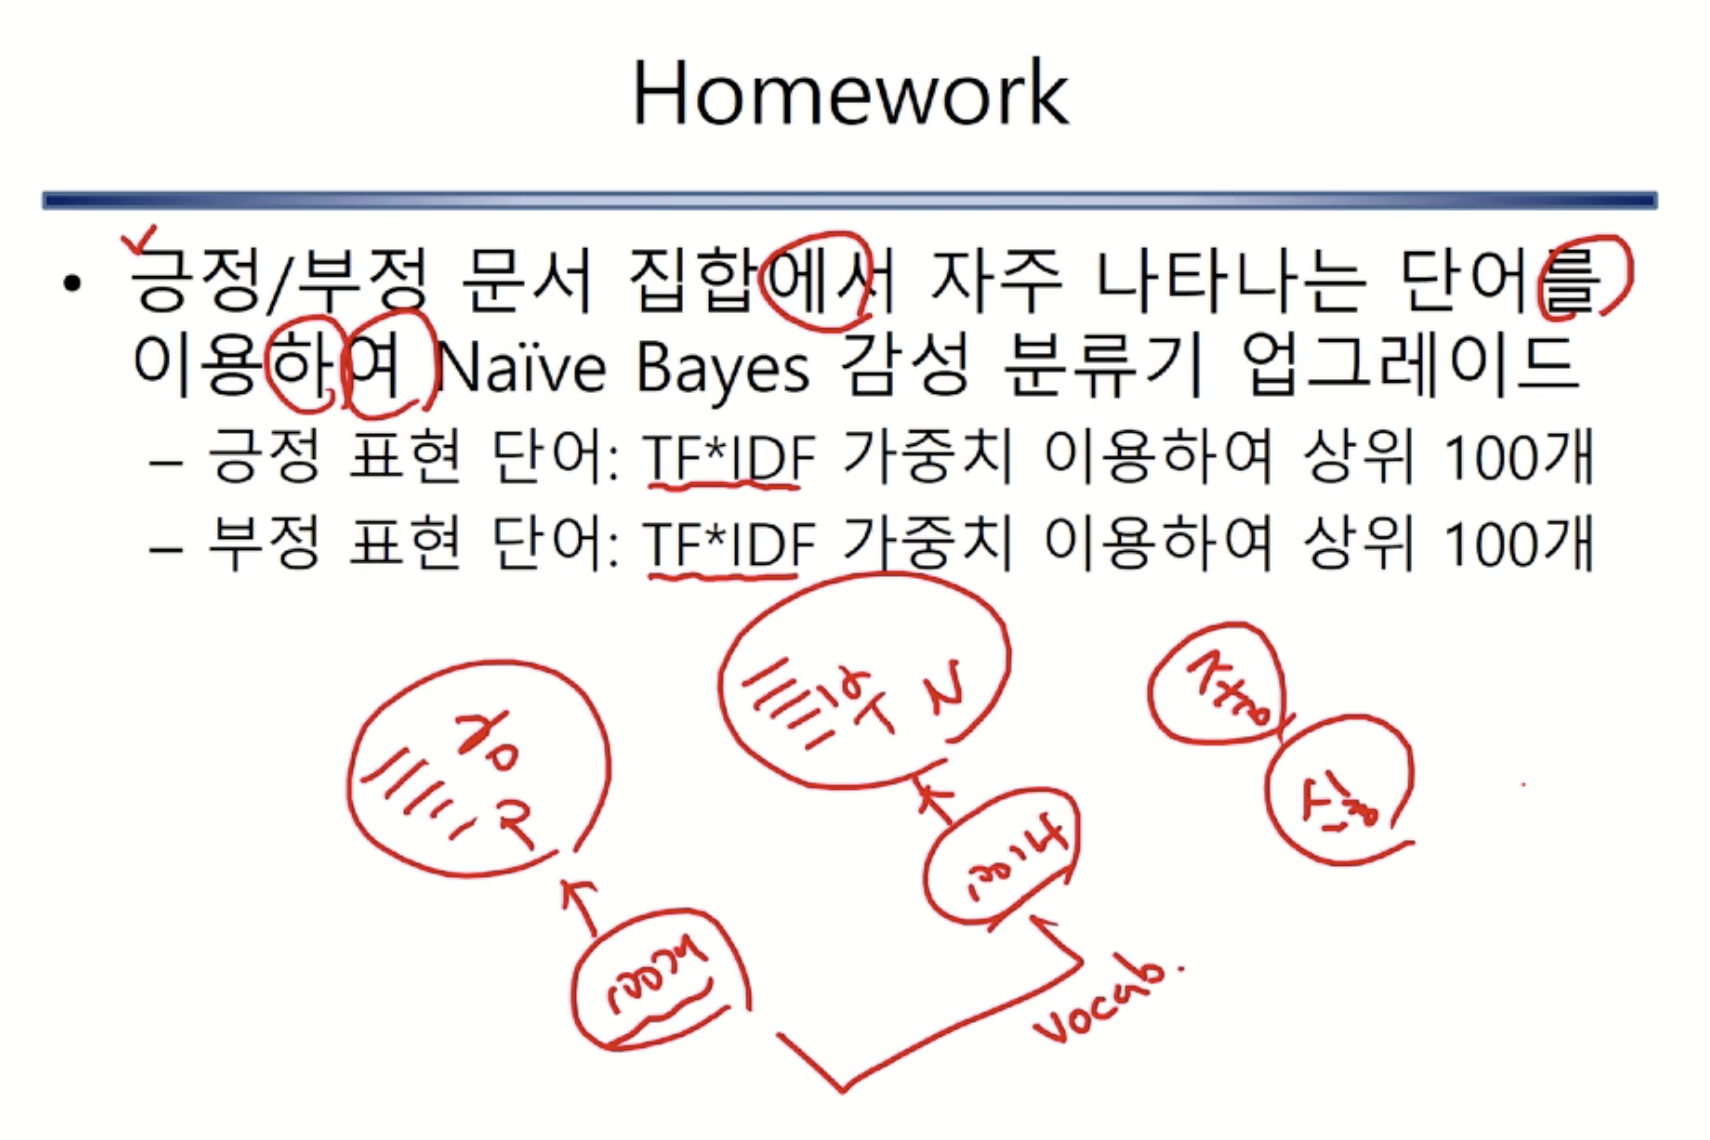

In [1]:
# ready
import pandas as pd
import numpy as np

import sys
np.set_printoptions(threshold=sys.maxsize)
import os
import tqdm
import warnings
warnings.filterwarnings(action='ignore')

from IPython.display import display
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

# visualization
from matplotlib import pyplot as plt

In [2]:
# sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer 
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

In [3]:
import re
import string

### step1. Load data
sentiment data, train 과 test 를 가져온다.

In [4]:
# load 함수
data_dir = 'data'

def load_data(file_path):
  file = open(os.path.join(data_dir, file_path))

  texts, labels = [], []

  for line in file.readlines():
    text, label = line.strip().split('\t')
    texts.append(text)
    labels.append(label)
  # data frame
  df = pd.DataFrame({'text':texts,'label':labels})

  return texts, labels, df

In [5]:
# data set
X_train, y_train, df_train = load_data('sentiment_train.txt')
X_test, y_test, df_test = load_data('sentiment_test.txt')

# train data 와 label 확인
df_train.head()

,text,label
0,제품 도 너무 너무 맘 에 들 ㄴ답니다,<P>
1,집사 라 미 드럼 세탁기 를 싫 어 하 ㅂ니다,<N>
2,너무 좋 아요,<P>
3,조금 작 은 감 이 있 지만 잘 쓰 ㄹ께 요,<N>
4,통 돌 이 너무너무 조왕,<P>


### step3. Tokenizing
긍정 문서와 부정 문서를 만들고 토크나이징한다.

In [6]:
# 긍정/부정 data frame
df_pos = df_train[df_train.label=='<P>']
df_neg = pos = df_train[df_train.label=='<N>']

# 확인
df_pos.head()

,text,label
0,제품 도 너무 너무 맘 에 들 ㄴ답니다,<P>
2,너무 좋 아요,<P>
4,통 돌 이 너무너무 조왕,<P>
6,잘 빨리 지 도 않 고 전기세 도 많이 들어가 ㄴ다고 그래서 통 돌 이 시키 었 는...,<P>
8,잘 받 았 고 요,<P>


In [7]:
# 데이터 프레임을 리스트로 만들어서 하나의 문서로 합쳐준다.
pos_doc = ' '.join(df_pos.text.tolist())
neg_doc = ' '.join(df_neg.text.tolist())

# 기호 불용어 처리
pos_doc = pos_doc.translate(str.maketrans('','',string.punctuation))
neg_doc = neg_doc.translate(str.maketrans('','',string.punctuation))

# 확인
pos_doc[:500]

'제품 도 너무 너무 맘 에 들 ㄴ답니다 너무 좋 아요 통 돌 이 너무너무 조왕 잘 빨리 지 도 않 고 전기세 도 많이 들어가 ㄴ다고 그래서 통 돌 이 시키 었 는데 가격 도 저렴 하 고 아주 좋 아요 잘 받 았 고 요 만족 하 ㅂ니다 가격 대비 매우 만족 하 ㅂ니다 덥 ㄴ데 감사 드리 어요 근데 새로 오 ㄴ 제품 사용 하 아 보 니 잘 돌아가 고 암튼 만족 이 ㅂ니다 배송 하 시 는 분 들 이 친절 하 게 수평 다 맞추 어 주 시 어서 감사 하 ㅂ니다 소음 도 적 고 좋 네요 매우 만족 하 ㅂ니다 제 가 시간 이 안 되 어서 참 맞추 기 힘들엇는데도끝까지최선을 다 하 아 주 시 어서 감사 하 ㅂ니다 좋 네요 설치 하 시 는 분 도 친절 하 시 고 세탁기 도 맘 에 들 어요 지 마켓 만원 할인 쿠폰 을 이용 하 아서 싸 게 사 아서 더욱 좋 구요 근데 무지 조용 하 구 예쁘데요 적극 추천 하 ㅂ니다 식구 많 지 않 구 특히혼자 살 시 는 분 이 아이 몸집 이 작 구 예쁘 다 하 니 딱'

In [8]:
# 띄어쓰기 기준으로 Tokenizing
pos_voca = [p for p in pos_doc.split()]
neg_voca = [n for n in neg_doc.split()]
# 확인
pos_voca[:100]

['제품',
 '도',
 '너무',
 '너무',
 '맘',
 '에',
 '들',
 'ㄴ답니다',
 '너무',
 '좋',
 '아요',
 '통',
 '돌',
 '이',
 '너무너무',
 '조왕',
 '잘',
 '빨리',
 '지',
 '도',
 '않',
 '고',
 '전기세',
 '도',
 '많이',
 '들어가',
 'ㄴ다고',
 '그래서',
 '통',
 '돌',
 '이',
 '시키',
 '었',
 '는데',
 '가격',
 '도',
 '저렴',
 '하',
 '고',
 '아주',
 '좋',
 '아요',
 '잘',
 '받',
 '았',
 '고',
 '요',
 '만족',
 '하',
 'ㅂ니다',
 '가격',
 '대비',
 '매우',
 '만족',
 '하',
 'ㅂ니다',
 '덥',
 'ㄴ데',
 '감사',
 '드리',
 '어요',
 '근데',
 '새로',
 '오',
 'ㄴ',
 '제품',
 '사용',
 '하',
 '아',
 '보',
 '니',
 '잘',
 '돌아가',
 '고',
 '암튼',
 '만족',
 '이',
 'ㅂ니다',
 '배송',
 '하',
 '시',
 '는',
 '분',
 '들',
 '이',
 '친절',
 '하',
 '게',
 '수평',
 '다',
 '맞추',
 '어',
 '주',
 '시',
 '어서',
 '감사',
 '하',
 'ㅂ니다',
 '소음',
 '도']

### step3. Vectorizer, tfidf
긍정단어들 문서와 부정단어들 문서의 tfidf 를 구해서 상위 100개를 각각 뽑는다.

tf idf 정의

In [9]:
# 각각 단어 수 세기
from collections import Counter
freq_pos = Counter(pos_voca)
freq_neg = Counter(neg_voca)

pos = pd.DataFrame.from_dict(freq_pos,orient='index',columns=['tf'])
neg = pd.DataFrame.from_dict(freq_neg,orient='index',columns=['tf'])

pos.head()

,tf
제품,65
도,547
너무,129
맘,55
에,254


In [10]:
# idf 
# outer join 된 데이터 프레임에서 df 와 idf 를 만든다.
df = pd.merge(pos, neg, left_on = pos.index, right_on = neg.index, how='outer')
df.columns=['word','pos_tf','neg_tf']
df.head(10)

,word,pos_tf,neg_tf
0,제품,65.0,44.0
1,도,547.0,239.0
2,너무,129.0,92.0
3,맘,55.0,18.0
4,에,254.0,337.0
5,들,138.0,116.0
6,ㄴ답니다,2.0,1.0
7,좋,417.0,155.0
8,아요,168.0,84.0
9,통,11.0,33.0


In [11]:
# idf
df['df'] = df.iloc[:,1:3].notnull().sum(axis = 1)     # 단어가 나온 문서의 수
df['idf'] = np.log(2/df.df)      # n = 2
df = df.fillna(0)
df

,word,pos_tf,neg_tf,df,idf
0,제품,65.0,44.0,2,0.000000
1,도,547.0,239.0,2,0.000000
2,너무,129.0,92.0,2,0.000000
3,맘,55.0,18.0,2,0.000000
4,에,254.0,337.0,2,0.000000
...,...,...,...,...,...
2670,일주,0.0,1.0,1,0.693147
2671,물어니,0.0,1.0,1,0.693147
2672,그러면,0.0,1.0,1,0.693147
2673,건성,0.0,2.0,1,0.693147


In [12]:
# weight 구하기
pos_tfidf = pd.merge(pos,df['idf'],left_on = pos.index, right_on = df.word,how='left')
pos_tfidf['weight'] = pos_tfidf['tf']*pos_tfidf['idf']

neg_tfidf = pd.merge(neg,df['idf'],left_on = neg.index, right_on = df.word,how='left')
neg_tfidf['weight'] = neg_tfidf['tf']*neg_tfidf['idf']

# 긍정/부정 단어 각 상위 10개
print(pos_tfidf.sort_values(by=['weight'], axis=0, ascending=False).head(10))
print(neg_tfidf.sort_values(by=['weight'], axis=0, ascending=False).head(10))

     key_0  tf       idf    weight
93      적극  12  0.693147  8.317766
597    사용법  10  0.693147  6.931472
455      철  10  0.693147  6.931472
940     고민   9  0.693147  6.238325
375     강추   8  0.693147  5.545177
645     세심   5  0.693147  3.465736
762     여러   5  0.693147  3.465736
151      쏙   5  0.693147  3.465736
448  강추합니다   5  0.693147  3.465736
470     모습   4  0.693147  2.772589
     key_0  tf       idf     weight
396     짜증  24  0.693147  16.635532
714    하지만  23  0.693147  15.942385
167     더니  22  0.693147  15.249238
74     그런데  20  0.693147  13.862944
687     그것  19  0.693147  13.169796
68      다시  18  0.693147  12.476649
49      다만  17  0.693147  11.783502
1162    실망  15  0.693147  10.397208
484     라는  15  0.693147  10.397208
852     업체  13  0.693147   9.010913


각 문서 단어의 weight 값을 확인 후 weight 값이 바뀌는 적당한 곳에서 절사했다.   
긍정은 79개, 부정은 88개가 된다.

In [13]:
# 긍정/부정 단어 상위 100개씩 추출
pos100 = pos_tfidf.sort_values(by=['weight'], axis=0, ascending=False)[pos_tfidf['weight']>1].key_0.tolist()
neg100 = neg_tfidf.sort_values(by=['weight'], axis=0, ascending=False)[neg_tfidf['weight']>3].key_0.tolist()

# 각 단어리스트 확인
print('긍정',pos100)
print('부정',neg100)

# 긍정 부정 train data set 을 만든다.
train = pd.DataFrame(pos100+neg100)
train['label'] = 0
train['label'][:len(pos100)+1] = '<P>'
train['label'][len(pos100):] = '<N>'

X_train_ = train.iloc[:,0]
y_train_ = train.iloc[:,1]

긍정 ['적극', '사용법', '철', '고민', '강추', '세심', '여러', '쏙', '강추합니다', '모습', '좋구여', '가격싸고', '배려', '강추입니다', '기숙사', '강추예요', '어른', '당근', '전기', '베리', '가르치', '훌륭', '전용', '신속', '완벽', '부자', '행복', '잔', '제일', '굳이', '울', '넉넉', '나이드신', '강츄', '저렵', '섬유유연제가', '구조', '외부', '우', '시장', '이서', '쿠폰', '땀', '강추에요', '애기', '욕실', '상쾌', '바', '지르', '주정', '에다', '맞히', '불경기', '기원', '찾', '꼼꼼', '기쁘', '역', '사도', '공기방울', '중요', '안심', '효율', '대단히', '사시', '화면', '폐가', '굳', '작동법', '화이트', '구김', '국산', '장마철', '독신자', '주신', '뒤지', '외관', '하하', '관리법', '버튼', '엉킴도', '혼자사니깐딱인거같아요', '튼튼', '사고', '새해', '시험', '오히려', '생활']
부정 ['짜증', '하지만', '더니', '그런데', '그것', '다시', '다만', '실망', '라는', '업체', '그런', '언제', '취소', '시끄럽', '소비자', '문', '지연', '쯤', '나쁘', '장난', '태도', '습니까', '아쉽', '한테', '다면', '원래', '무슨', '어쩌', '얘기', '단점', '보내', '아무래도', '사실', '열', '밤', '어렵', '실', '다행', '소', '교환', '문의', '냐고', '약하', '몇일', '냐', '성의', '결제', '대충', '야', '그거', '아닌가요', '반품', '당일', '호스', 'ㅂ니까', '기본', '상하', '자체', '토요일', '목', '질문', '한가지', '재고', '저녁', '똑같', '배송만', '따로', '그러나', '조절', '휴', '쪽', '심'

### step4. Naive Bayes

In [14]:
# 새로운 단어사전에 fitting
vectorizer = CountVectorizer()
feature_X_train = vectorizer.fit_transform(X_train_)
feature_X_test = vectorizer.transform(X_test)

In [15]:
# train
clf = MultinomialNB()
clf.fit(feature_X_train, y_train_)

# prediction
y_pred = clf.predict(feature_X_test)

# evaluate score
print('Accuracy : %.2f'% accuracy_score(y_test,y_pred))

Accuracy : 0.66


### 비교 : Sklearn TfidfVectorizer 구현체

In [16]:
vectorizer = TfidfVectorizer()

feature_X_train = vectorizer.fit_transform(X_train)
feature_X_test = vectorizer.transform(X_test)

In [17]:
# train
clf = MultinomialNB()
clf.fit(feature_X_train, y_train)

# prediction
y_pred = clf.predict(feature_X_test)

# evaluate score
print('Accuracy : %.2f'% accuracy_score(y_test,y_pred))

Accuracy : 0.84


tf idf 를 구하고 긍정/부정 단어들이 있는 단어사전을 만들고 fitting 시키는 과정이   
1주차 과제를 스스로 참고했다고하나 거의 하드 코딩이었다. 
사이킷런 구현체를 쓰지 않으면서도 쉽게 사전을 만드는 방법이 있을 것 같은데 못찾았다.  
또한 겹치는 단어를 tf idf 가 최대한 걸러내기를 바랬으나, 겹치는 단어가 있어서 Accuracy는 사이킷런보다 20퍼센트 낮은 0.66에 그친다.